In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import month, year, when, col
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/ds625/climate_puerto_ayora.csv")


In [0]:
spark = SparkSession.builder.appName("ClimateAnalysis").getOrCreate()

In [0]:
df1.show()

+----------------+------------+------------+-------------+--------+--------+-------------+--------------+------+
|observation_date|min_air_temp|max_air_temp|mean_air_temp|sea_temp|humidity|precipitation|sunshine_hours|clouds|
+----------------+------------+------------+-------------+--------+--------+-------------+--------------+------+
|      1964-12-31|        22.2|        30.8|         26.1|    25.8|      82|         0.00|          null|     4|
|      1965-01-01|        21.0|        25.8|         23.9|    22.7|      84|         0.70|          null|     8|
|      1965-01-02|        21.1|        26.2|         23.4|    22.4|      83|         0.00|          null|     3|
|      1965-01-03|        22.0|        26.6|         23.7|    23.1|      81|         0.00|          null|     7|
|      1965-01-04|        null|        26.6|         24.0|    23.1|      79|         0.30|          null|     4|
|      1965-01-05|        22.2|        26.8|         24.1|    23.1|      84|         0.00|      

In [0]:
# Extract year from observation_date column
# Register climate as a temporary view
df1 = df1.withColumn("year", year(col("observation_date")))
df1.createOrReplaceTempView("climate")

# query to calculate yearly total precipitation
query = """
    SELECT 
        year, 
        SUM(precipitation) AS total_precipitation
    FROM climate
    GROUP BY year
    ORDER BY year
"""

result = spark.sql(query)
result.show()


+----+-------------------+
|year|total_precipitation|
+----+-------------------+
|1964|                0.0|
|1965|  600.0300000000003|
|1966| 203.79999999999984|
|1967|  277.2499999999999|
|1968| 163.81000000000003|
|1969| 469.80000000000007|
|1970|  85.55000000000003|
|1971| 269.50000000000017|
|1972|  669.0999999999997|
|1973| 469.39999999999986|
|1974| 174.35000000000008|
|1975|  929.0999999999997|
|1976|  506.4000000000002|
|1977|  268.4000000000001|
|1978|              418.2|
|1979| 169.70000000000002|
|1980| 255.79999999999993|
|1981| 369.79999999999984|
|1982|  639.4500000000002|
|1983| 2768.6999999999985|
+----+-------------------+
only showing top 20 rows



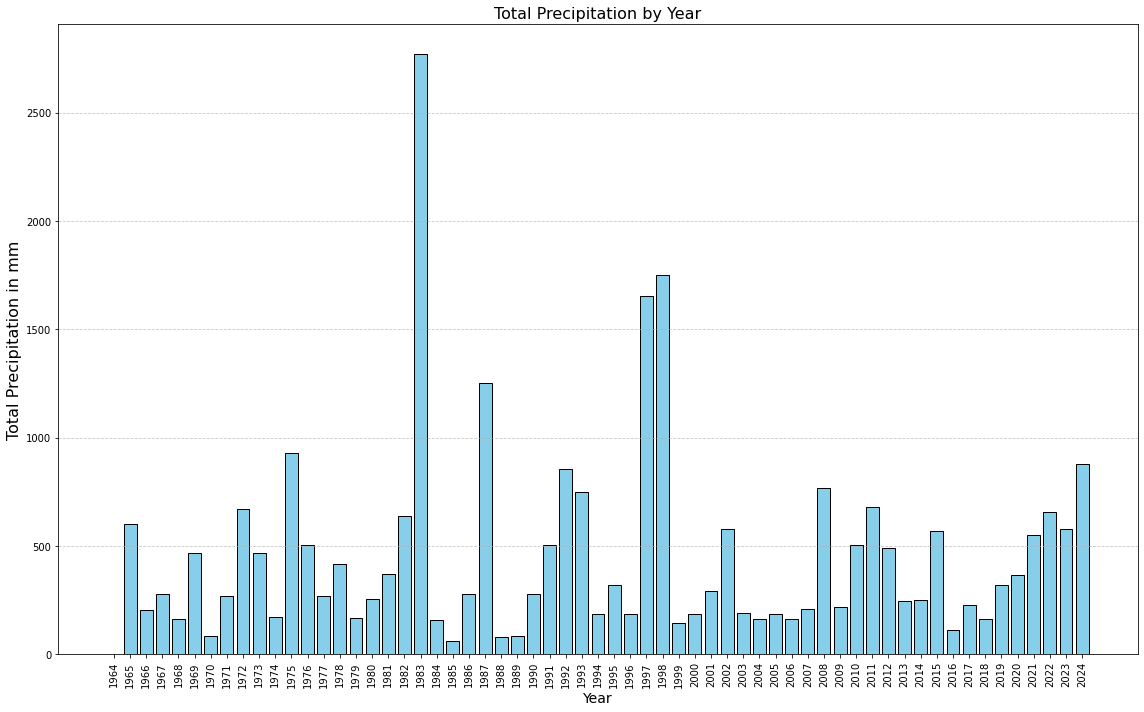

In [0]:
# convert result to a pandas and plot it
all_years_df = result.toPandas()

plt.figure(figsize=(16, 10))
plt.bar(all_years_df["year"], all_years_df["total_precipitation"], color='skyblue', edgecolor='black')
plt.title("Total Precipitation by Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Precipitation in mm", fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(all_years_df["year"], rotation=90)
plt.tight_layout()
plt.show()

In [0]:
# this spark sql query is converting the other data to yearly stats
query = """
    SELECT 
        YEAR(observation_date) AS year,
        ROUND(MAX(max_air_temp), 2) AS max_air_temp_year,
        ROUND(MIN(min_air_temp), 2) AS min_air_temp_year,
        ROUND(AVG(mean_air_temp), 2) AS avg_mean_air_temp,
        ROUND(AVG(sea_temp), 2) AS avg_sea_temp,
        ROUND(AVG(humidity), 2) AS avg_humidity,
        ROUND(SUM(precipitation), 2) AS total_precipitation_year
    FROM climate
    GROUP BY YEAR(observation_date)
    ORDER BY year
"""

yearly_stats = spark.sql(query)
total_rows = yearly_stats.count()
yearly_stats.show(total_rows, truncate=False)

+----+-----------------+-----------------+-----------------+------------+------------+------------------------+
|year|max_air_temp_year|min_air_temp_year|avg_mean_air_temp|avg_sea_temp|avg_humidity|total_precipitation_year|
+----+-----------------+-----------------+-----------------+------------+------------+------------------------+
|1964|30.8             |22.2             |26.1             |25.8        |82.0        |0.0                     |
|1965|33.0             |18.4             |24.69            |24.65       |81.62       |600.03                  |
|1966|32.6             |16.8             |23.21            |22.91       |83.44       |203.8                   |
|1967|33.1             |16.7             |23.04            |22.64       |85.21       |277.25                  |
|1968|32.4             |16.5             |23.37            |22.97       |83.86       |163.81                  |
|1969|33.4             |16.1             |24.89            |24.63       |83.68       |469.8             

In [0]:
# Bit like previously but I broke it down by into 2 seasons
# Warm and wet season December to June, Coold and dry is July to December
query = """
    WITH period_data AS (
        SELECT 
            YEAR(observation_date) AS year,
            CASE
                WHEN MONTH(observation_date) BETWEEN 1 AND 6 THEN 'January-June'
                WHEN MONTH(observation_date) BETWEEN 6 AND 12 THEN 'July-December'
            END AS period,
            max_air_temp,
            min_air_temp,
            mean_air_temp,
            sea_temp,
            humidity,
            precipitation
        FROM climate
    )
    SELECT 
        year,
        period,
        ROUND(MAX(max_air_temp), 2) AS max_air_temp_period,
        ROUND(MIN(min_air_temp), 2) AS min_air_temp_period,
        ROUND(AVG(mean_air_temp), 2) AS avg_mean_air_temp,
        ROUND(AVG(sea_temp), 2) AS avg_sea_temp,
        ROUND(AVG(humidity), 2) AS avg_humidity,
        ROUND(SUM(precipitation), 2) AS total_precipitation_year
    FROM period_data
    GROUP BY year, period
    ORDER BY 
        year,
        CASE
            WHEN period = 'March-June' THEN 1
            WHEN period = 'July-October' THEN 2
        END
"""

periodic_stats_year = spark.sql(query)
total_rows = periodic_stats_year.count()
periodic_stats_year.show(total_rows, truncate=False)

+----+-------------+-------------------+-------------------+-----------------+------------+------------+------------------------+
|year|period       |max_air_temp_period|min_air_temp_period|avg_mean_air_temp|avg_sea_temp|avg_humidity|total_precipitation_year|
+----+-------------+-------------------+-------------------+-----------------+------------+------------+------------------------+
|1964|July-December|30.8               |22.2               |26.1             |25.8        |82.0        |0.0                     |
|1965|January-June |33.0               |21.0               |26.06            |25.81       |82.09       |494.43                  |
|1965|July-December|27.9               |18.4               |23.39            |23.51       |81.17       |105.6                   |
|1966|January-June |32.6               |17.4               |25.05            |24.09       |83.19       |120.5                   |
|1966|July-December|27.0               |16.8               |21.55            |21.76       

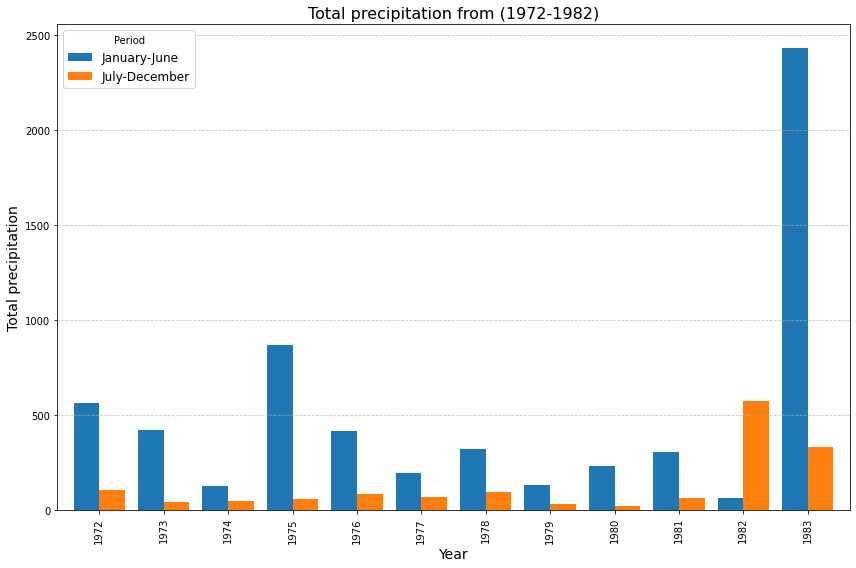

In [0]:
# here the data show the drought from late 1976 to 1977 with a lower than normal wet season
periodic_year_stats = periodic_stats_year.toPandas()
filtered_periodic_year_stats = periodic_year_stats[(periodic_year_stats['year'] >= 1972) & (periodic_year_stats['year'] <= 1983)]
pivot_periodic_year_stats = filtered_periodic_year_stats.pivot(index='year', columns='period', values='total_precipitation_year')

pivot_periodic_year_stats.plot(kind='bar', figsize=(12, 8), width=0.8)
plt.title("Total precipitation from (1972-1982)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total precipitation", fontsize=14)
plt.legend(title="Period", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

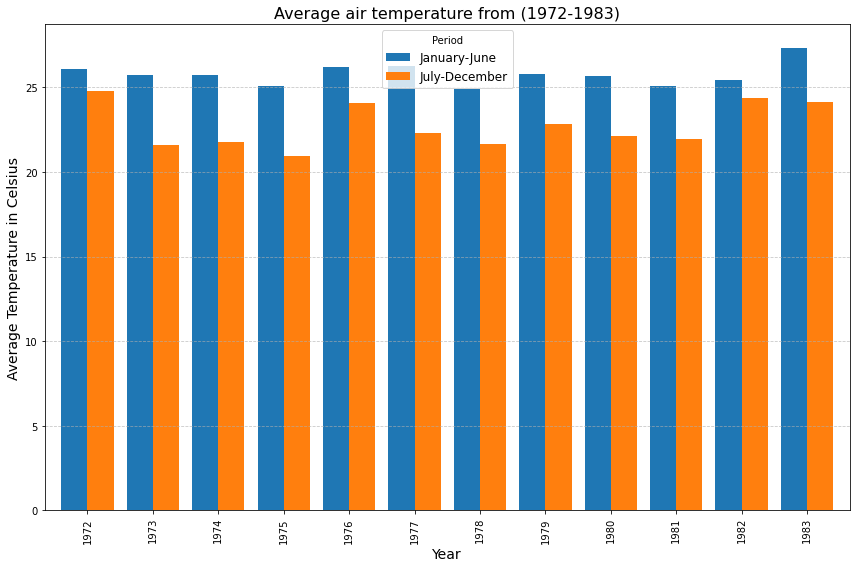

In [0]:

pivot_periodic_year_stats_air_temp = filtered_periodic_year_stats.pivot(index='year', columns='period', values='avg_mean_air_temp')
pivot_periodic_year_stats_air_temp.plot(kind='bar', figsize=(12, 8), width=0.8)
plt.title("Average air temperature from (1972-1983)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Temperature in Celsius", fontsize=14)
plt.legend(title="Period", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

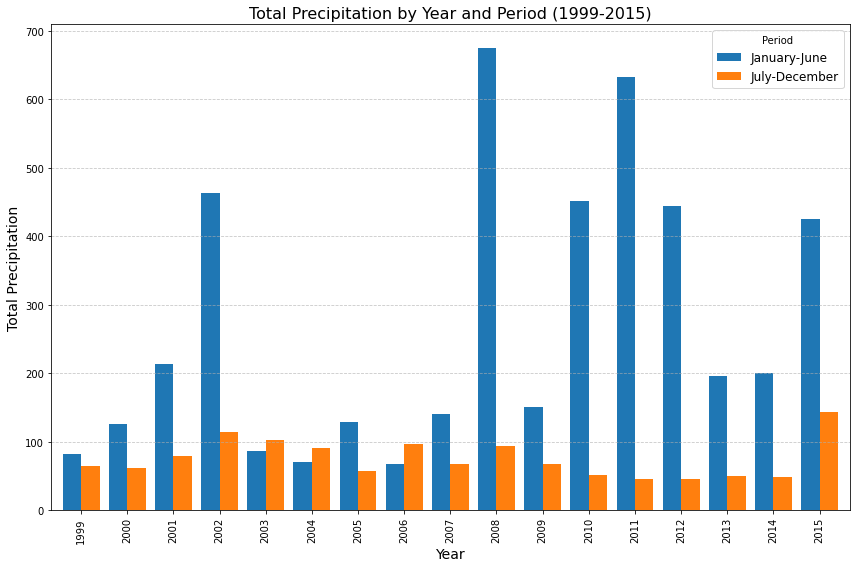

In [0]:
early_2000s = periodic_year_stats[(periodic_year_stats['year'] >= 1999) & (periodic_year_stats['year'] <= 2015)]
pivot_early_2000s = early_2000s.pivot(index='year', columns='period', values='total_precipitation_year')


pivot_early_2000s.plot(kind='bar', figsize=(12, 8), width=0.8)
plt.title("Total Precipitation by Year and Period (1999-2015)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Precipitation", fontsize=14)
plt.legend(title="Period", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


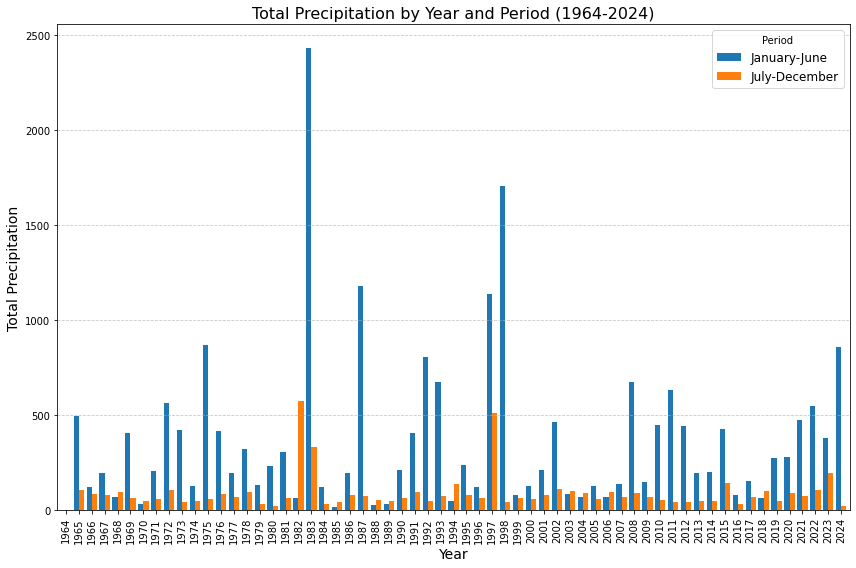

In [0]:
# early_2000s = periodic_year_stats[(periodic_year_stats['year'] >= 1999) & (periodic_year_stats['year'] <= 2015)]
pivot_periodic_year_stats = periodic_year_stats.pivot(index='year', columns='period', values='total_precipitation_year')


pivot_periodic_year_stats.plot(kind='bar', figsize=(12, 8), width=0.8)
plt.title("Total Precipitation by Year and Period (1964-2024)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Precipitation", fontsize=14)
plt.legend(title="Period", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [0]:
df2 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/ds625/finch_beaks_1975-2.csv")
df2.show()

+----+-------+---------------+--------------+
|band|species|Beak length, mm|Beak depth, mm|
+----+-------+---------------+--------------+
|   2| fortis|            9.4|             8|
|   9| fortis|            9.2|           8.3|
|  12| fortis|            9.5|           7.5|
|  15| fortis|            9.5|             8|
| 305| fortis|           11.5|           9.9|
| 307| fortis|           11.1|           8.6|
| 308| fortis|            9.9|           8.4|
| 309| fortis|           11.5|           9.8|
| 311| fortis|           10.8|           9.2|
| 312| fortis|           11.3|             9|
| 313| fortis|           11.5|           9.5|
| 314| fortis|           11.5|           8.9|
| 315| fortis|            9.7|           8.8|
| 316| fortis|           10.9|           9.7|
| 316| fortis|           10.9|          9.85|
| 320| fortis|           10.1|           8.9|
| 321| fortis|           10.6|           8.5|
| 323| fortis|            9.6|           8.2|
| 324| fortis|           10.3|    

In [0]:
df3 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/ds625/finch_beaks_2012-2.csv")
df3.show()

+-----+-------+-------+------+
| band|species|blength|bdepth|
+-----+-------+-------+------+
|19022| fortis|     10|   8.5|
|19028| fortis|   12.5|   8.9|
|19032| fortis|    9.3|   7.5|
|19041| fortis|   10.3|   9.6|
|19044| fortis|     11|   9.2|
|19048| fortis|   10.1|   8.2|
|19072| fortis|    9.6|   7.8|
|19082| fortis|   10.9|   8.6|
|19104| fortis|   10.3|   8.4|
|19114| fortis|    9.8|   7.7|
|19121| fortis|   10.1|     8|
|19126| fortis|   10.4|   8.7|
|19146| fortis|    9.6|   8.1|
|19164| fortis|   10.6|   8.8|
|19174| fortis|   10.6|   9.4|
|19203| fortis|   11.9|    10|
|19210| fortis|   11.3|   9.6|
|19217| fortis|   11.3|   9.6|
|19224| fortis|    9.7|   8.1|
|19226| fortis|    9.7|   7.5|
+-----+-------+-------+------+
only showing top 20 rows



In [0]:
# bird counts
species_count_1975 = df2.groupBy("species").count()
species_count_1975.show()

species_count_2012 = df3.groupBy("species").count()
species_count_2012.show()

# finding the averages averages
average_stats1 = df2.groupBy("species").agg(
    {"Beak length, mm": "avg", "Beak depth, mm": "avg"}
).withColumnRenamed("avg(Beak length, mm)", "avg_beak_length_1975").withColumnRenamed("avg(Beak depth, mm)", "avg_beak_depth_1975")

average_stats2 = df3.groupBy("species").agg(
    {"blength": "avg", "bdepth": "avg"}
).withColumnRenamed("avg(blength)", "avg_beak_length_2012").withColumnRenamed("avg(bdepth)", "avg_beak_depth_2012")

average_stats1.show()
average_stats2.show()


+--------+-----+
| species|count|
+--------+-----+
|  fortis|  316|
|scandens|   87|
+--------+-----+

+--------+-----+
| species|count|
+--------+-----+
|  fortis|  121|
|scandens|  127|
+--------+-----+

+--------+--------------------+-------------------+
| species|avg_beak_length_1975|avg_beak_depth_1975|
+--------+--------------------+-------------------+
|  fortis|  10.565189873417724|  9.171645569620255|
|scandens|  14.120919540229883|               8.96|
+--------+--------------------+-------------------+

+--------+--------------------+-------------------+
| species|avg_beak_length_2012|avg_beak_depth_2012|
+--------+--------------------+-------------------+
|  fortis|  10.517355371900827|  8.605371900826446|
|scandens|  13.421023622047247|  9.186220472440944|
+--------+--------------------+-------------------+



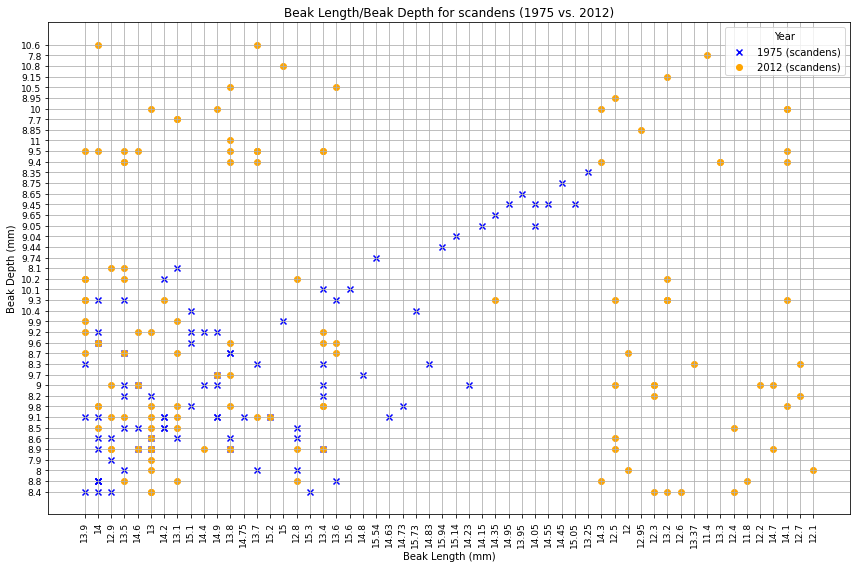

In [0]:
data_1975 = df2.toPandas()
data_2012 = df3.toPandas()

# filterring for scandens species
data_1975_scandens = data_1975[data_1975["species"] == "scandens"]
data_2012_scandens = data_2012[data_2012["species"] == "scandens"]

plt.figure(figsize=(12, 8))

# Plot 1975
plt.scatter(
    data_1975_scandens["Beak length, mm"],
    data_1975_scandens["Beak depth, mm"],
    marker='x',
    color='blue',
    label="1975 (scandens)"
)

# Plot 2012
plt.scatter(
    data_2012_scandens["blength"],
    data_2012_scandens["bdepth"],
    marker='o',
    color='orange',
    label="2012 (scandens)"
)

# Add titles and labels
plt.title("Beak Length/Beak Depth for scandens (1975 vs. 2012)", fontsize=12)
plt.xlabel("Beak Length (mm)", fontsize=10)
plt.ylabel("Beak Depth (mm)", fontsize=10) 
plt.legend(title="Year", fontsize=10)
plt.grid(True)
plt.xticks(fontsize=9, rotation=90)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


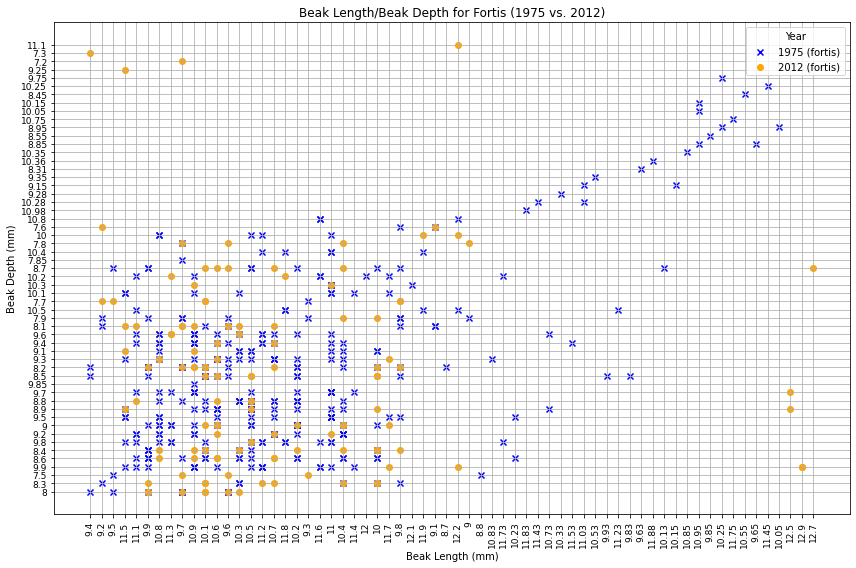

In [0]:


# filterring for fortis species
data_1975_fortis = data_1975[data_1975["species"] == "fortis"]
data_2012_fortis = data_2012[data_2012["species"] == "fortis"]

plt.figure(figsize=(12, 8))

# Plot 1975
plt.scatter(
    data_1975_fortis["Beak length, mm"],
    data_1975_fortis["Beak depth, mm"],
    marker='x',
    color='blue',
    label="1975 (fortis)"
)

# Plot 2012
plt.scatter(
    data_2012_fortis["blength"],
    data_2012_fortis["bdepth"],
    marker='o',
    color='orange',
    label="2012 (fortis)"
)

# Add titles and labels
plt.title("Beak Length/Beak Depth for Fortis (1975 vs. 2012)", fontsize=12)
plt.xlabel("Beak Length (mm)", fontsize=10)
plt.ylabel("Beak Depth (mm)", fontsize=10) 
plt.legend(title="Year", fontsize=10)
plt.grid(True)
plt.xticks(fontsize=9, rotation=90)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()
